In [1]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [4]:
dilution_type = 'dilution_CC'
prlfr_type = 'Prlfr_CC'

In [5]:
### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('H1299_Rotenone_Asp-level.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k][dilution_type]
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [6]:
metab_names_mes

['Adenosine pos',
 'ADP pos',
 'Alanine pos',
 'AMP pos',
 'Arginine pos',
 'Argininosuccinate neg',
 'Asparagine pos',
 'Aspartate neg',
 'Carbamoylaspartate neg',
 'Cis-aconitate neg',
 'CMP neg',
 'Dihydroorotate neg',
 'Fumarate neg',
 'Glutamate neg',
 'Glutamine pos',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'Glycine neg',
 'GMP pos',
 'IMP pos',
 'Isoleucine pos',
 'Lactate neg',
 'Leucine pos',
 'Lysine pos',
 'Malate neg',
 'NAD pos',
 'NADH pos',
 'Ornithine pos',
 'Phenylalanine pos',
 'Proline pos',
 'Pyruvate neg',
 'Serine neg',
 'Succinate neg',
 'Taurine pos',
 'Threonine neg',
 'Tryptophan pos',
 'Tyrosine pos',
 'UDP neg',
 'UMP neg',
 'Uridine neg',
 'Valine pos']

In [7]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam][dilution_type].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam][dilution_type].values

In [8]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['Pyr-Lac'] = (df['Pyruvate neg'] / df['Lactate neg']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

In [9]:
df_mean = df.groupby(['Rotenone', 'Treatment']).mean().reset_index()
df_stdev = df.groupby(['Rotenone', 'Treatment']).std().reset_index()
df_stdev['Prlfr_CC'] = df_mean['Prlfr_CC_stdev']
df_stdev['Prlfr_CC'] = df_mean['Prlfr_CC_stdev']

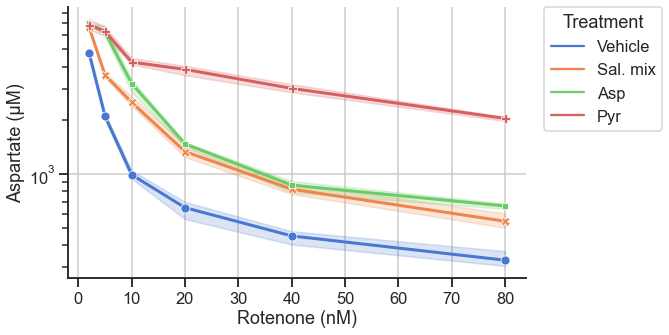

In [35]:
### Aspartate as a function of Metformin ###

fig, ax1 = plt.subplots(1, 1, figsize=(8.2, 5))

mask = (df['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df[mask], x='Rotenone', y='Aspartate conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.set(yscale="log")

g1.set_xlabel('Rotenone (nM)')
g1.set_ylabel('Aspartate (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.savefig('plots/Rotenone-Aspartate.pdf', bbox_inches='tight')

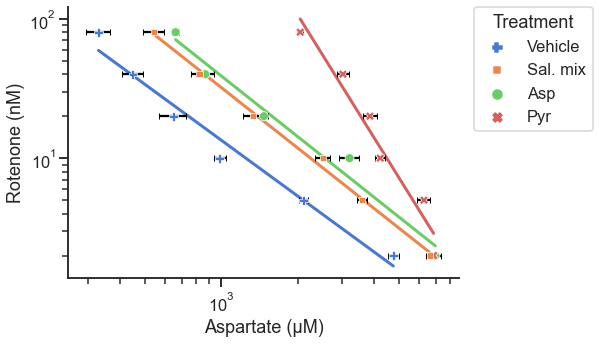

In [36]:
### Aspartate as a function of Metformin log linear ###

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

mask = (df['Rotenone'] < 160) & (df['Rotenone'] > 0) & ~((df['Rotenone'] == 5) & (df['Treatment'] == 'Asp'))
mask_mean = (df_mean['Rotenone'] < 160) & (df_mean['Rotenone'] > 0) & ~((df_mean['Rotenone'] == 5) & (df_mean['Treatment'] == 'Asp'))
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.scatterplot(ax=ax1, data=df_mean[mask_mean], y='Rotenone', x='Aspartate conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, zorder=11, s=80)
g1.errorbar(y=df_mean[mask_mean]['Rotenone'].values, x=df_mean[mask_mean]['Aspartate conc'].values, xerr=df_stdev[mask_mean]['Aspartate conc'].values, fmt='none', color='black', capsize=3, zorder=10)

g1.set(yscale="log", xscale="log")

g1.set_ylabel('Rotenone (nM)')
g1.set_xlabel('Aspartate (μM)')

if True:
    for trment in hue_order:
        ### Fit regression ###
        x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask_mean]['Aspartate conc'], df_mean[mask_mean]['Treatment']) if b == trment ])
        y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask_mean]['Rotenone'], df_mean[mask_mean]['Treatment']) if b == trment ])

        b_no, m_no = polyfit(x_no, y_no, 1)

        ax1.plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3)

        ######################

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

#g1.grid(True)
sns.despine()
fig.savefig('plots/Rotenone-Aspartate_loglin.pdf', bbox_inches='tight')

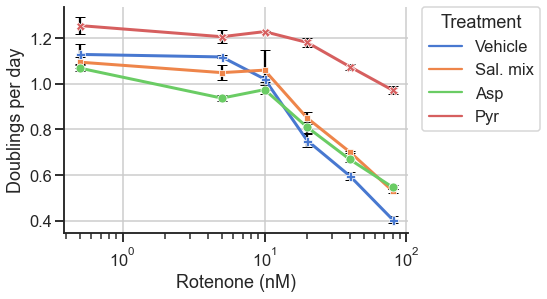

In [35]:
### Proliferation as a function of Rotenone ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Rotenone', y=prlfr_type, hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask][prlfr_type].values, x=df_mean[mask]['Rotenone'].values, yerr=df_stdev[mask][prlfr_type].values, fmt='none', color='black', capsize=5, zorder=1)
g1.set(xscale="log")

g1.set_xlabel('Rotenone (nM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Rotenone-Prlfr.pdf', bbox_inches='tight')

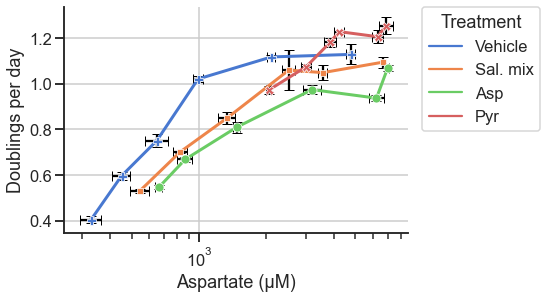

In [73]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y=prlfr_type, hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask][prlfr_type].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask][prlfr_type].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)
g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Prlfr.pdf', bbox_inches='tight')

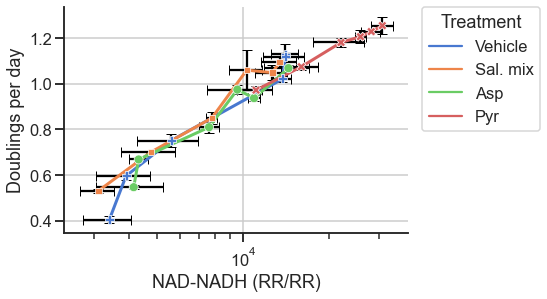

In [46]:
### Proliferation as a function of NAD-NADH ratio ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.scatterplot(ax=ax1, data=df_mean[mask], x='NAD-NADH', y=prlfr_type, hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, zorder=10)
g1.errorbar(y=df_mean[mask][prlfr_type].values, x=df_mean[mask]['NAD-NADH'].values, yerr=df_stdev[mask][prlfr_type].values, xerr=df_stdev[mask]['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('NAD-NADH (RR/RR)')
g1.set_ylabel('Doublings per day')

g2 = sns.lineplot(ax=ax1, data=df_mean[mask], x='NAD-NADH', y=prlfr_type, hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=False, dashes=False, linewidth=3, zorder=5)
g2.set(xscale="log")

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles[0:4], labels[0:4], title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/NAD-NADH-Prlfr.pdf', bbox_inches='tight')

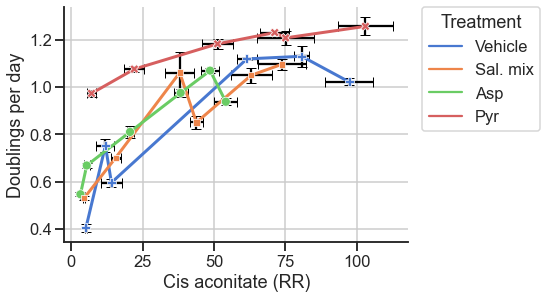

In [49]:
### Proliferation as a function of Citrate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.scatterplot(ax=ax1, data=df_mean[mask], x='Cis-aconitate neg', y=prlfr_type, hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, zorder=10)
g1.errorbar(y=df_mean[mask][prlfr_type].values, x=df_mean[mask]['Cis-aconitate neg'].values, yerr=df_stdev[mask][prlfr_type].values, xerr=df_stdev[mask]['Cis-aconitate neg'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Cis aconitate (RR)')
g1.set_ylabel('Doublings per day')

g2 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Cis-aconitate neg', y=prlfr_type, hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=False, dashes=False, linewidth=3, zorder=5)
#g2.set(xscale="log")

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles[0:4], labels[0:4], title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Cis-aconitate-Prlfr.pdf', bbox_inches='tight')

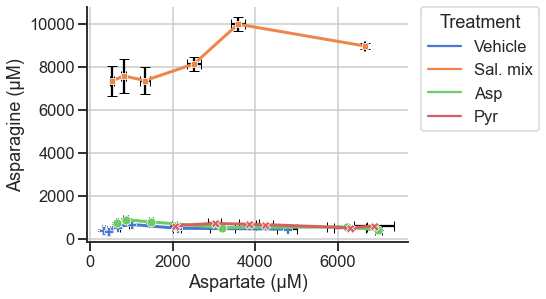

In [75]:
### Asparagine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Asparagine conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Asparagine conc'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Asparagine conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Asparagine (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Asparagine.pdf', bbox_inches='tight')

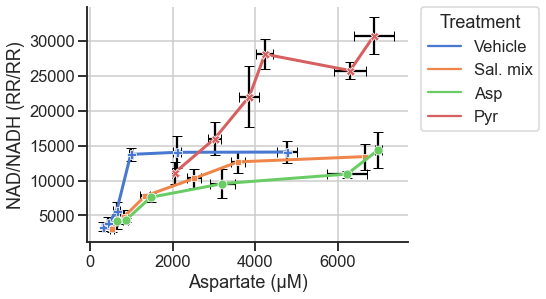

In [76]:
### NAD/NADH as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='NAD-NADH', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['NAD-NADH'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['NAD-NADH'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('NAD/NADH (RR/RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-NAD-NADH.pdf', bbox_inches='tight')

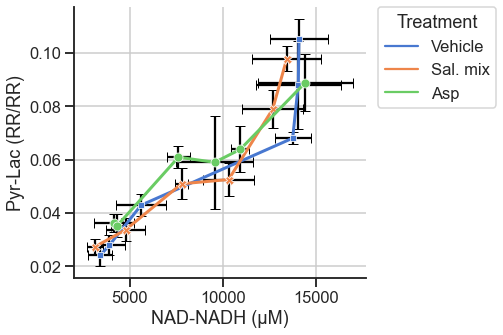

In [77]:
### Pyr-Lac ratio as a function of NAD-NADH ratio ###

fig, ax1 = plt.subplots(1, 1, figsize=(7.4, 5))

mask = (df_mean['Rotenone'] < 160) & (df_mean['Treatment'] != 'Pyr')
hue_order = ['Vehicle', 'Sal. mix', 'Asp']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='NAD-NADH', y='Pyr-Lac', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean[mask]['Pyr-Lac'].values, x=df_mean[mask]['NAD-NADH'].values, yerr=df_stdev[mask]['Pyr-Lac'].values, xerr=df_stdev[mask]['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('NAD-NADH (μM)')
g1.set_ylabel('Pyr-Lac (RR/RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/NAD-NADH-Pyr-Lac.pdf', bbox_inches='tight')

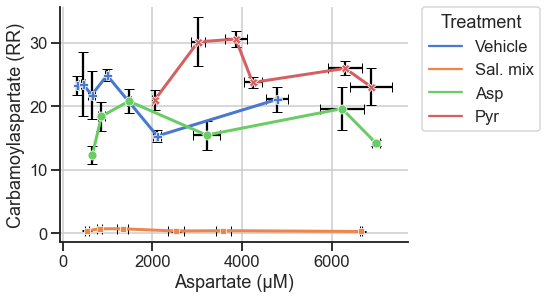

In [78]:
### Carbamoylaspartate as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Carbamoylaspartate neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Carbamoylaspartate neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Carbamoylaspartate neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Carbamoylaspartate (RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Carbamoylaspartate.pdf', bbox_inches='tight')

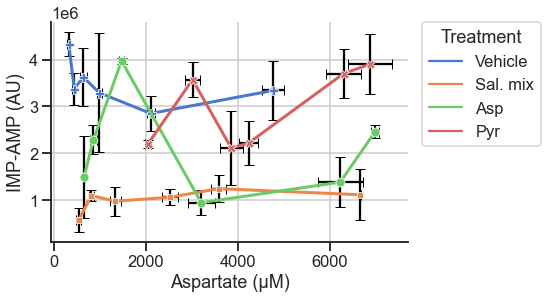

In [79]:
### IMP-AMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='IMP-AMP', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['IMP-AMP'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['IMP-AMP'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('IMP-AMP (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-IMP-AMP.pdf', bbox_inches='tight')

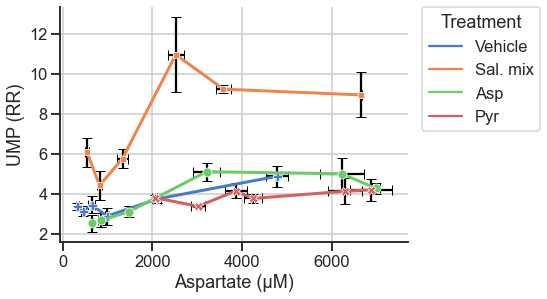

In [80]:
### UMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='UMP neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['UMP neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['UMP neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('UMP (RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-UMP.pdf', bbox_inches='tight')

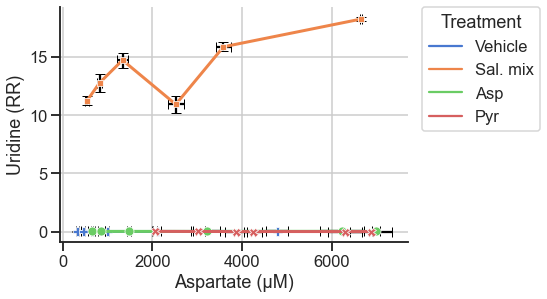

In [81]:
### Uridine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Uridine neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Uridine neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Uridine neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Uridine (RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Uridine.pdf', bbox_inches='tight')

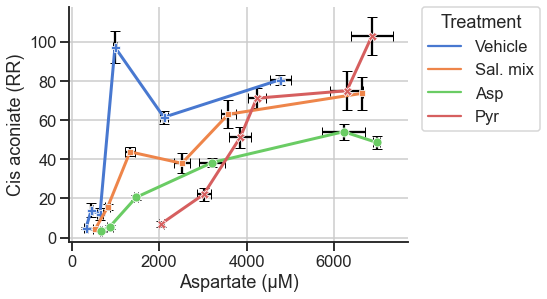

In [43]:
### Citrate as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = (df_mean['Rotenone'] < 160)
hue_order = ['Vehicle', 'Sal. mix', 'Asp', 'Pyr']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Cis-aconitate neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Cis-aconitate neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Cis-aconitate neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Cis aconiate (RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Cisaconitate.pdf', bbox_inches='tight')

In [52]:
metab_names_mes

['Adenosine pos',
 'ADP pos',
 'Alanine pos',
 'AMP pos',
 'Arginine pos',
 'Argininosuccinate neg',
 'Asparagine pos',
 'Aspartate neg',
 'Carbamoylaspartate neg',
 'Cis-aconitate neg',
 'CMP neg',
 'Dihydroorotate neg',
 'Fumarate neg',
 'Glutamate neg',
 'Glutamine pos',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'Glycine neg',
 'GMP pos',
 'IMP pos',
 'Isoleucine pos',
 'Lactate neg',
 'Leucine pos',
 'Lysine pos',
 'Malate neg',
 'NAD pos',
 'NADH pos',
 'Ornithine pos',
 'Phenylalanine pos',
 'Proline pos',
 'Pyruvate neg',
 'Serine neg',
 'Succinate neg',
 'Taurine pos',
 'Threonine neg',
 'Tryptophan pos',
 'Tyrosine pos',
 'UDP neg',
 'UMP neg',
 'Valine pos']

In [56]:
df[mask]

,Sample ID,ISTD Amt,Sample_name,Treatment,Replicate,Rotenone,Prlfr_CC,Prlfr_IC,Prlfr_CC_stdev,Prlfr_IC_stdev,...,Tryptophan pos,Tyrosine pos,UDP neg,UMP neg,Uridine neg,Valine pos,NAD-NADH,Pyr-Lac,IMP-AMP,GSH-GSSG
0,RS01,1,RS01,Vehicle,1,2,1.129754,1.032380,0.043816,0.022271,...,3.489928,18.137302,6.988856,4.358191,0.019967,24.462690,15823.243811,0.110047,2.988934e+06,2.036578
1,RS02,1,RS02,Vehicle,2,2,1.129754,1.032380,0.043816,0.022271,...,3.186822,16.644609,6.806635,4.833909,0.015540,22.591362,13495.726275,0.109056,4.068903e+06,2.375210
2,RS03,1,RS03,Vehicle,3,2,1.129754,1.032380,0.043816,0.022271,...,3.527309,18.414549,9.097932,5.432639,0.019427,24.691981,12909.352278,0.096654,2.964433e+06,1.913767
3,RS04,1,RS04,Sal. mix,1,2,1.095612,1.055522,0.024176,0.030615,...,3.120881,16.203239,17.256882,10.245904,18.073688,22.377035,11688.512579,0.094844,6.891609e+05,1.565890
4,RS05,1,RS05,Sal. mix,2,2,1.095612,1.055522,0.024176,0.030615,...,3.189381,16.265052,12.467476,8.399000,18.250452,22.905234,15376.098187,0.095484,1.726803e+06,2.489877
5,RS06,1,RS06,Sal. mix,3,2,1.095612,1.055522,0.024176,0.030615,...,3.150787,16.420970,15.557517,8.198600,18.367477,22.556052,13203.801118,0.103152,9.323054e+05,2.072746
60,RS61,1,RS61,Vehicle,1,80,0.404446,0.384872,0.015641,0.012282,...,2.729827,14.415694,3.539538,3.410462,0.021313,20.982243,2807.552052,0.028238,4.037305e+06,2.422098
61,RS62,1,RS62,Vehicle,2,80,0.404446,0.384872,0.015641,0.012282,...,2.461268,12.835702,4.661713,3.537257,0.015186,19.208808,3324.410436,0.023570,4.509176e+06,1.996266
62,RS63,1,RS63,Vehicle,3,80,0.404446,0.384872,0.015641,0.012282,...,2.364828,12.582311,4.021914,3.188148,0.014698,18.239001,4087.583407,0.020322,4.458239e+06,2.582341
63,RS64,1,RS64,Sal. mix,1,80,0.530501,0.476411,0.010226,0.017896,...,2.536483,12.690789,7.752579,5.426208,11.655685,18.018234,3100.049201,0.029344,4.688294e+05,2.524373


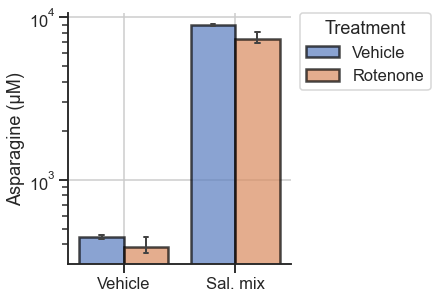

In [81]:
### Asparagine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))

mask = ((df['Rotenone'] == 2) | (df['Rotenone'] == 80)) & (df['Treatment'] != 'Asp') & (df['Treatment'] != 'Pyr')
hue_order = [2, 80]
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Asparagine conc', hue='Rotenone',
             hue_order=hue_order, edgecolor='black', linewidth=2.5, alpha=0.7, ci=95, capsize=.04, errwidth=2,)
g1.set(yscale="log")
g1.set_xlabel('')
g1.set_ylabel('Asparagine (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['Vehicle', 'Rotenone']
title = 'Treatment'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Asparagine.pdf', bbox_inches='tight')